In [4]:
import torch
import torch.nn.functional as F
from models import Create_nets
from datasets import Get_dataloader
from options import TrainOptions
from torchvision import models
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from PIL import Image

import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [41]:
type='cable'
DATA_PATH='/home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection'
NORMAL_PATH = DATA_PATH + f'/{type}/train/good'
ANOMALY_PATH = DATA_PATH + f'/{type}/test'
normal_images=[os.path.join(NORMAL_PATH,item) for item in os.listdir(NORMAL_PATH)]
file_path = []
for root, dirs, files in os.walk(ANOMALY_PATH):
    for file in files:
        file_path.append( os.path.join(root, file))
anomaly_images=[item for item in file_path if "good" not in item]
good_images_test=[item for item in file_path if "good" in item]
print(f'type {type}, normals {len(normal_images)}, anomalies {len(anomaly_images)}, good_images_test {len(good_images_test)}')

type cable, normals 224, anomalies 92, good_images_test 58


In [53]:

class ImageDataset(Dataset):
    def __init__(self, image_paths,mode='train'):
        self.image_paths = image_paths
        self.crop_size = 256
        self.mode = mode
        self.transform = transforms.Compose([ transforms.Resize((self.crop_size, self.crop_size), Image.BICUBIC),
                                        transforms.Pad(int(self.crop_size/10),fill=0,padding_mode='constant'),
                                        transforms.RandomRotation(10),
                                        transforms.RandomCrop((self.crop_size, self.crop_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225 ])
                                        ])
        self.transform_test = transforms.Compose([ transforms.Resize((self.crop_size, self.crop_size), Image.BICUBIC),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225 ])
                                                ])
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        img = Image.open(image_path)
        img = img.convert('RGB')
        
        if self.mode == 'test':
            image = self.transform_test(img)
        else:
            image = self.transform(img)
        return image


dataset_good = ImageDataset(normal_images)
train_loader = DataLoader(dataset_good, batch_size=32, shuffle=True,)

dataset_anomalies = ImageDataset(anomaly_images)
test_loader = DataLoader(dataset_anomalies, batch_size=1, shuffle=True)

dataset_test_good = ImageDataset(good_images_test)
test_loader_good = DataLoader(dataset_test_good, batch_size=1, shuffle=True)

def embedding_concat(x, y):
    B, C1, H1, W1 = x.size()
    _, C2, H2, W2 = y.size()
    s = int(H1 / H2)
    x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
    x = x.view(B, C1, -1, H2, W2)
    z = torch.zeros(B, C1 + C2, x.size(2), H2, W2).to(device)
    for i in range(x.size(2)):
        z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), 1)
    z = z.view(B, -1, H2 * W2)
    z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)

    return z

In [30]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Ensure output is in the [0, 1] range
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [39]:
backbone = models.resnet18(pretrained=True).to(device)
backbone.eval()
cae=Autoencoder().to(device)

import torch.optim as optim

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(cae.parameters(), lr=0.001)


def hook(module, input, output):
    outputs.append(output)
backbone.layer1[-1].register_forward_hook(hook)
backbone.layer2[-1].register_forward_hook(hook)
backbone.layer3[-1].register_forward_hook(hook)


for epoch in range(0, 100):
    for i,batch in enumerate(train_loader):
        running_loss = 0.0

        with torch.no_grad():
            inputs = batch.to(device)
            outputs = []
            _ = backbone(inputs)     
            outputs = embedding_concat(embedding_concat(outputs[0],outputs[1]),outputs[2])
        # get the mean for eahch image in the batch
        mean_tensor = torch.mean(outputs, dim=1).unsqueeze(1)   
        #print(f'mean_tensor.shape: {mean_tensor.shape}')     
        # Zero the gradients
        optimizer.zero_grad()
        outputs2 = cae(mean_tensor)
        loss = criterion(outputs2, mean_tensor)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(running_loss)


0.06673362851142883
0.0665389746427536
0.06604264676570892
0.06502348184585571
0.06499533355236053
0.06403856724500656
0.06377123296260834
0.06325144320726395
0.06244891136884689
0.0615784153342247
0.06079297140240669
0.05976226553320885
0.058367811143398285
0.05693001300096512
0.055482737720012665
0.05300896614789963
0.050382718443870544
0.047707051038742065
0.04455522447824478
0.040889739990234375
0.03722406178712845
0.033534467220306396
0.030365750193595886
0.0276211928576231
0.02537710592150688
0.023310404270887375
0.021712806075811386
0.02001204714179039
0.018965434283018112
0.0183512382209301
0.01749754697084427
0.016675956547260284
0.015593077056109905
0.014727331697940826
0.01391778513789177
0.013007927685976028
0.012175525538623333
0.011070610955357552
0.010048555210232735
0.009365524165332317
0.008756173774600029
0.008479615673422813
0.008237294852733612
0.008019870147109032
0.007626472972333431
0.007203570567071438
0.006682284642010927
0.006075660232454538
0.0056218472309410

KeyboardInterrupt: 

In [54]:
eval_mse=nn.MSELoss()

torch.no_grad()

outputs_new = []
for i,batch in enumerate(test_loader):
    with torch.no_grad():
        inputs = batch.to(device)
        outputs = []
        _ = backbone(inputs)     
        outputs = embedding_concat(embedding_concat(outputs[0],outputs[1]),outputs[2])
    # get the mean for eahch image in the batch
    mean_tensor = torch.mean(outputs, dim=1).unsqueeze(1)  
    outputs2 = cae(mean_tensor)
    outputs_new.append(eval_mse(outputs2, mean_tensor))
    



In [55]:
outputs_new

[tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(

In [49]:
mean_tensor = torch.mean(outputs, dim=1)
# images=mean_tensor.cpu().numpy()# outputs[2,:64,:,:].cpu().numpy()
images=torch.Tensor(outputs_new).squeeze().cpu().numpy()
num_images = images.shape[0]
num_rows = int(num_images ** 0.5)
num_cols = num_images // num_rows
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 20))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='viridis')
    ax.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.05)  # Adjust the spacing between subplots
plt.show()

ValueError: only one element tensors can be converted to Python scalars

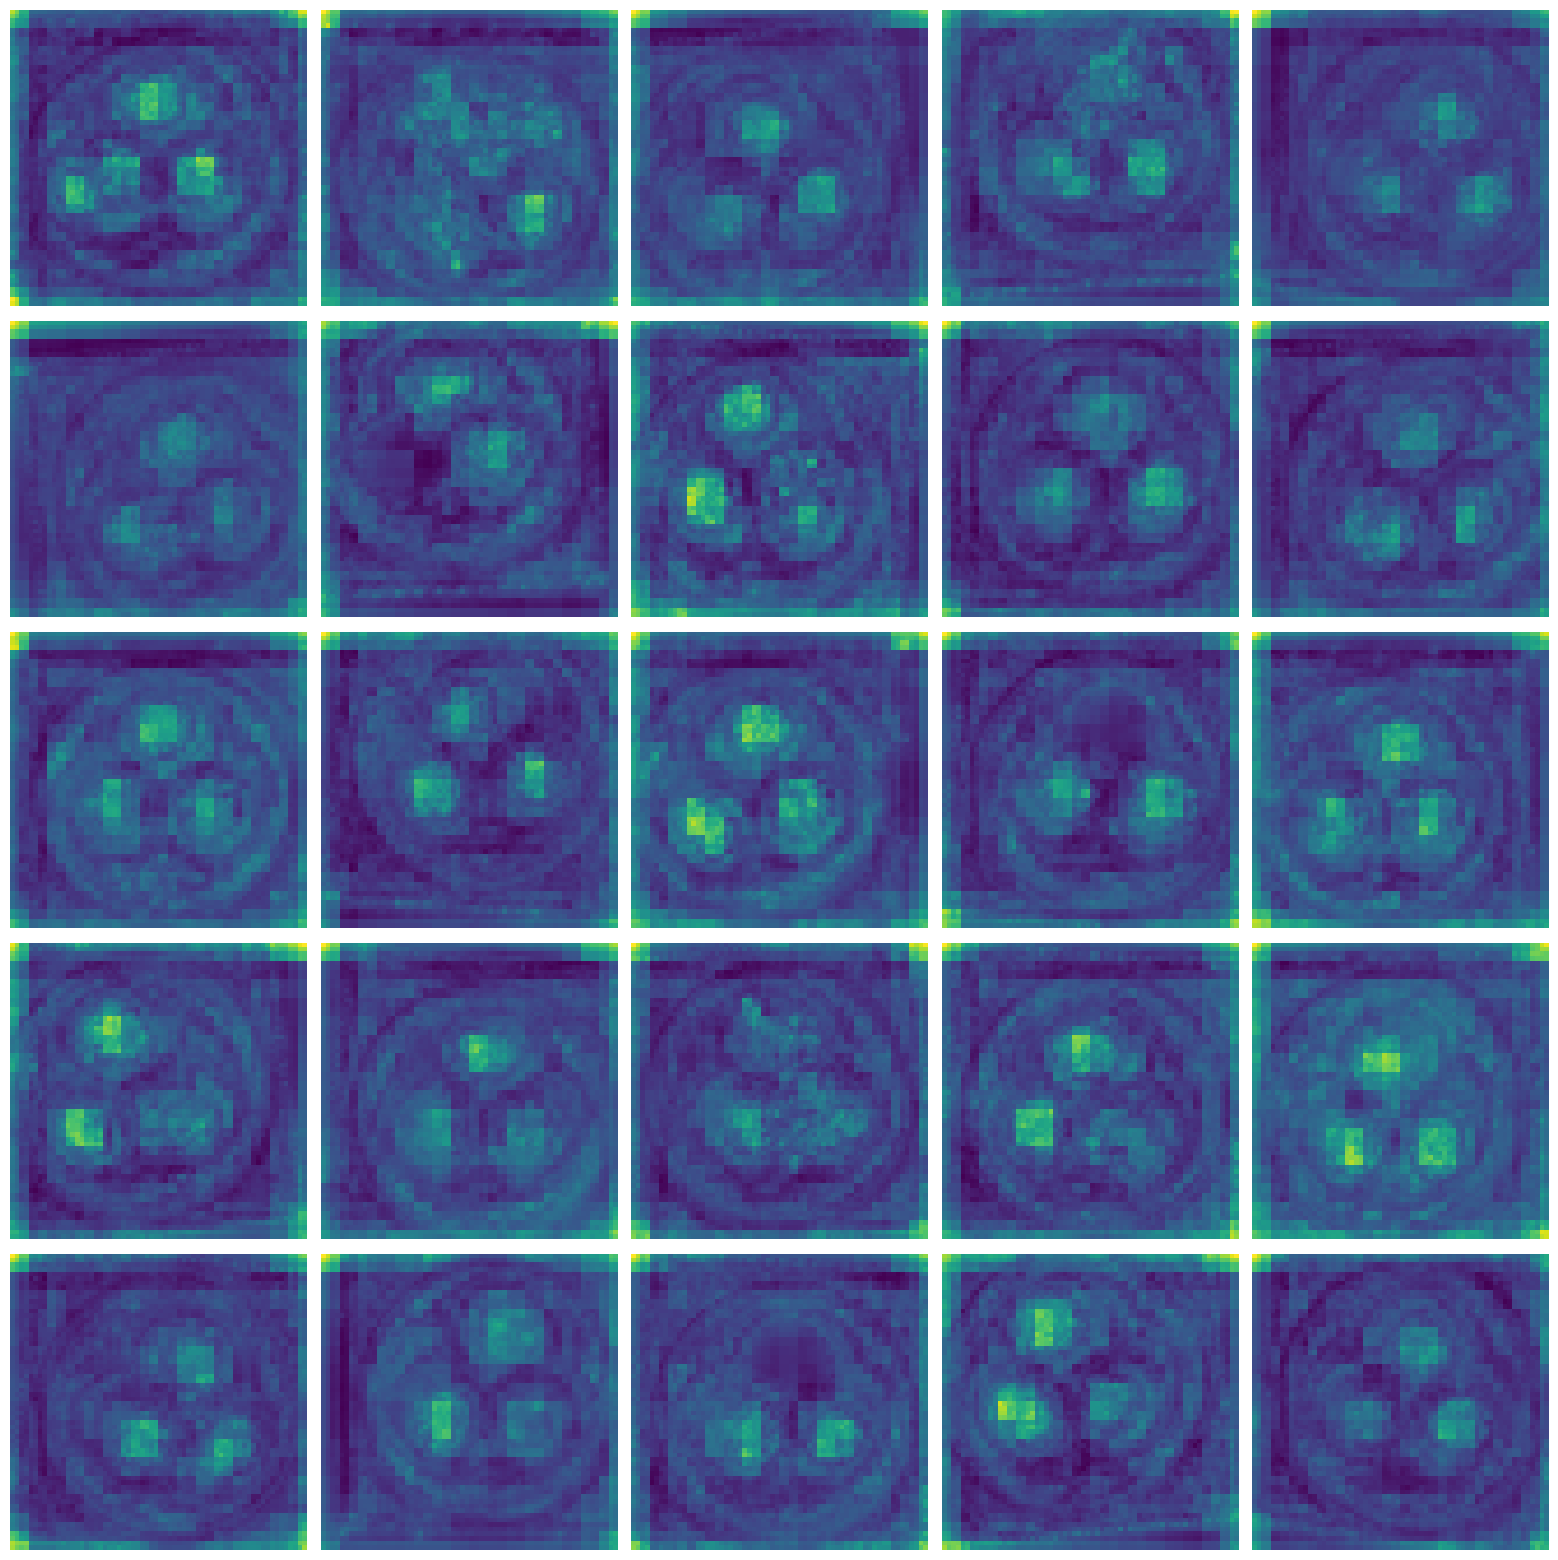

In [19]:
mean_tensor = torch.mean(outputs, dim=1)
images=mean_tensor.cpu().numpy()# outputs[2,:64,:,:].cpu().numpy()
num_images = images.shape[0]
num_rows = int(num_images ** 0.5)
num_cols = num_images // num_rows
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 20))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='viridis')
    ax.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.05)  # Adjust the spacing between subplots
plt.show()